## Introduction: Keynes, Friedman, Modigliani

In [1]:
# Some initial setup
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Dark2')

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import datetime as dt
import scipy.stats as stats
import statsmodels.formula.api as sm
from copy  import deepcopy

#import pandas_datareader.data as web
# As of 09/03/2019 the latest available version of pandas-datareader
# has conflicts with the latest version of pandas. We temporarily fix
# this by loading data from files.
# This should not be necessary when pandas-datareader>0.7 becomes available.
from io import StringIO

from HARK.ConsumptionSaving.ConsIndShockModel import PerfForesightConsumerType
from HARK.utilities import plotFuncsDer, plotFuncs

### 1. The Keynesian consumption function

Keynes:
1. "The amount of aggregate consumption mainly depends on the amount of aggregate income."
1. "It is a "fundamental psychological rule ... that when ... real income increases ... consumption [will increase], but by less than the increase in income."
1. More generally, "as a rule, a greater proportion of income ... is saved as real income increases."

This can be formalized as:

$
\begin{eqnarray}
c_t & = &  a_0 + a_{1}y_t
\\ c_t - c_{t-1} & = & a_{1}(y_t - y_{t-1})
\end{eqnarray}
$

for $a_0 > 0, a_1 < 1$


#### The Keynesian Consumption Function

In [2]:
class KeynesianConsumer:
    """
    This class represents consumers that behave according to a
    Keynesian consumption function, representing them as a
    special case of HARK's PerfForesightConsumerType
    
    Methods:
    - cFunc: computes consumption/permanent income 
             given total income/permanent income.
    """
    
    def __init__(self):
        
        PFexample = PerfForesightConsumerType() # set up a consumer type and use default parameteres
        PFexample.cycles = 0 # Make this type have an infinite horizon
        PFexample.DiscFac = 0.05
        PFexample.PermGroFac = [0.7]

        PFexample.solve() # solve the consumer's problem
        PFexample.unpackcFunc() # unpack the consumption function
        
        self.cFunc = PFexample.solution[0].cFunc
        self.a0 = self.cFunc(0)
        self.a1 = self.cFunc(1) - self.cFunc(0)

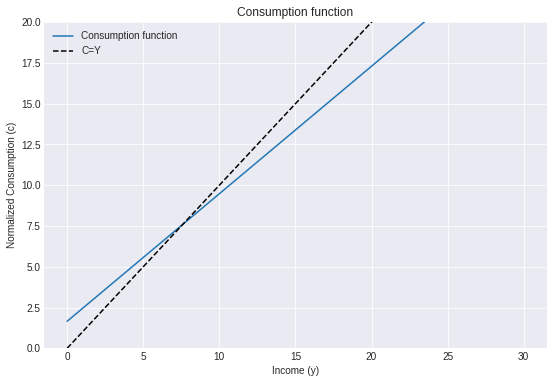

In [3]:
# Plot cFunc(Y)=Y against the Keynesian consumption function
# Deaton-Friedman consumption function is a special case of perfect foresight model

# We first create a Keynesian consumer
KeynesianExample = KeynesianConsumer()

# and then plot its consumption function
income = np.linspace(0, 30, 20) # pick some income points
plt.figure(figsize=(9,6))
plt.plot(income, KeynesianExample.cFunc(income), label = 'Consumption function') #plot income versus the consumption
plt.plot(income, income, 'k--', label = 'C=Y')
plt.title('Consumption function')
plt.xlabel('Income (y)')
plt.ylabel('Normalized Consumption (c)')
plt.ylim(0, 20)
plt.legend()
plt.show()

In [4]:
# This looks like the first of the three equations, consumption as a linear function of income!
# This means that even in a microfounded model (that HARK provides), the consumption function can match Keynes reduced form
# prediction (given the right parameterisation).

# We can even find a_0 and a_1
a_0 = KeynesianExample.a0
a_1 = KeynesianExample.a1
print('a_0 is ' + str(a_0))
print('a_1 is ' +  str(a_1))

a_0 is 1.6585489266336533
a_1 is 0.7818880665025854


#### The Keynesian consumption function: Evidence

Aggregate Data:

Long-term time-series estimates: $a_0$ close to zero, $a_1$ close to 1 (saving rate stable over time - Kuznets).<br>
Short-term aggregate time-series estimates of change in consumption on change in income find $a_1 << 1$.<br>
$c_t = a_0 + a_{1}y_t + a_{2}c_{t-1}$ finds significant $a_2$, near 1.

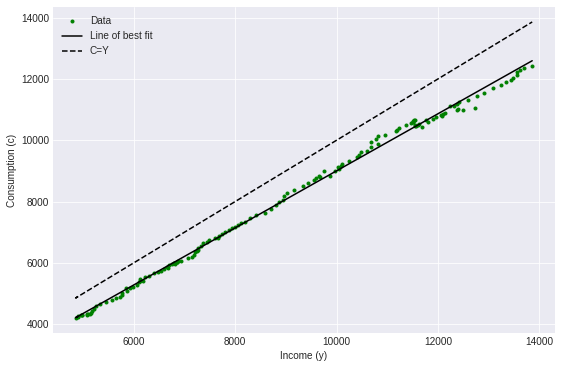

a_0 is -306.4339825308052
a_1 is 0.930807882378215


In [5]:
# Lets have a look at some aggregate data

sdt = dt.datetime(1980, 1, 1) #set startdate
edt = dt.datetime (2017, 1, 1) #set end date
# df = web.DataReader(["PCECC96", "DPIC96"], "fred", sdt, edt) #import the data from Fred
quarterly_data_string = """DATE,PCECC96,DPIC96
1980-01-01,4277.851,4893.069
1980-04-01,4181.51,4850.055
1980-07-01,4227.379,4904.532
1980-10-01,4284.494000000001,4972.057
1981-01-01,4298.847,4965.1
1981-04-01,4299.16,4970.894
1981-07-01,4319.0470000000005,5078.088
1981-10-01,4289.504,5083.669
1982-01-01,4321.1,5095.938
1982-04-01,4334.262,5126.682
1982-07-01,4363.318,5151.281
1982-10-01,4439.749,5167.46
1983-01-01,4483.645,5216.222
1983-04-01,4574.944,5252.3730000000005
1983-07-01,4656.982,5331.188
1983-10-01,4731.194,5449.929
1984-01-01,4770.457,5558.7919999999995
1984-04-01,4837.29,5651.1230000000005
1984-07-01,4873.165,5725.728
1984-10-01,4936.293,5772.469
1985-01-01,5020.163,5757.403
1985-04-01,5066.25,5869.535
1985-07-01,5162.475,5851.143
1985-10-01,5173.643,5913.044
1986-01-01,5218.851,5990.8
1986-04-01,5275.72,6067.419
1986-07-01,5369.049,6106.1
1986-10-01,5401.98,6115.403
1987-01-01,5407.371999999999,6171.7480000000005
1987-04-01,5481.166,6113.986999999999
1987-07-01,5543.723000000001,6223.4259999999995
1987-10-01,5555.451,6307.349
1988-01-01,5653.588000000001,6399.868
1988-04-01,5695.326,6465.76
1988-07-01,5745.933000000001,6528.255
1988-10-01,5811.264,6589.847
1989-01-01,5838.225,6664.871999999999
1989-04-01,5865.477,6645.224
1989-07-01,5922.2609999999995,6689.365
1989-10-01,5948.0,6745.986
1990-01-01,5998.058000000001,6797.794
1990-04-01,6016.329000000001,6845.103
1990-07-01,6040.1630000000005,6842.681
1990-10-01,5994.2119999999995,6784.328
1991-01-01,5971.672,6801.283
1991-04-01,6021.1630000000005,6851.0419999999995
1991-07-01,6051.184,6879.012
1991-10-01,6048.156,6936.2
1992-01-01,6161.398,7075.791
1992-04-01,6203.224,7145.956999999999
1992-07-01,6269.718000000001,7179.108
1992-10-01,6344.446,7211.805
1993-01-01,6368.772,7238.786999999999
1993-04-01,6426.703,7261.182
1993-07-01,6498.229,7267.508000000001
1993-10-01,6555.274,7318.014
1994-01-01,6630.253000000001,7366.339
1994-04-01,6681.840999999999,7440.526999999999
1994-07-01,6732.791,7483.9169999999995
1994-10-01,6805.581,7591.307
1995-01-01,6822.519,7656.201
1995-04-01,6882.33,7677.91
1995-07-01,6944.7,7748.26
1995-10-01,6993.144,7793.543000000001
1996-01-01,7057.641,7867.34
1996-04-01,7133.566,7939.476
1996-07-01,7176.754,8003.765
1996-10-01,7233.918000000001,8046.395
1997-01-01,7310.17,8123.031999999999
1997-04-01,7343.08,8195.02
1997-07-01,7468.188,8291.452
1997-10-01,7557.4490000000005,8413.567
1998-01-01,7633.895,8590.692
1998-04-01,7768.323,8708.815
1998-07-01,7869.624,8796.546999999999
1998-10-01,7983.316,8866.183
1999-01-01,8060.776,8946.329
1999-04-01,8178.302,8966.482
1999-07-01,8270.609,9027.655999999999
1999-10-01,8391.791,9163.245
2000-01-01,8520.71,9338.678
2000-04-01,8603.007,9441.952
2000-07-01,8687.485,9551.595
2000-10-01,8762.205,9585.735999999999
2001-01-01,8797.28,9672.598
2001-04-01,8818.079,9655.706
2001-07-01,8848.3,9878.502
2001-10-01,8980.61,9753.663
2002-01-01,9008.096,9973.532
2002-04-01,9054.348,10041.054
2002-07-01,9119.949,10032.3
2002-10-01,9172.360999999999,10091.868
2003-01-01,9215.501,10115.601
2003-04-01,9318.994,10238.895
2003-07-01,9455.687,10411.905
2003-10-01,9519.802,10439.34
2004-01-01,9604.507,10487.421
2004-04-01,9664.264000000001,10607.594
2004-07-01,9771.136,10676.851999999999
2004-10-01,9877.416,10811.704
2005-01-01,9935.048,10684.945
2005-04-01,10047.766,10786.45
2005-07-01,10145.296999999999,10818.34
2005-10-01,10175.424,10956.911
2006-01-01,10288.892,11170.065
2006-04-01,10341.016,11197.381000000001
2006-07-01,10403.798,11226.35
2006-10-01,10504.481000000002,11374.5
2007-01-01,10563.261,11471.408000000001
2007-04-01,10582.839,11500.783000000001
2007-07-01,10642.483,11510.998
2007-10-01,10672.794,11518.823999999999
2008-01-01,10644.428999999998,11550.819
2008-04-01,10661.688999999998,11762.205
2008-07-01,10581.856000000002,11515.015
2008-10-01,10483.376,11615.323999999999
2009-01-01,10459.698,11565.491000000002
2009-04-01,10417.334,11689.821000000002
2009-07-01,10489.202,11557.64
2009-10-01,10473.645,11554.792
2010-01-01,10525.431999999999,11619.753999999999
2010-04-01,10609.148000000001,11811.198999999999
2010-07-01,10683.341999999999,11895.286
2010-10-01,10753.999,11961.982
2011-01-01,10799.741000000002,12083.876
2011-04-01,10823.653999999999,12057.571000000002
2011-07-01,10866.036,12110.213
2011-10-01,10885.893,12147.876
2012-01-01,10973.303,12375.275
2012-04-01,10989.585,12487.781
2012-07-01,11007.517,12398.39
2012-10-01,11056.851999999999,12741.861
2013-01-01,11114.186000000002,12231.915
2013-04-01,11122.185,12323.044
2013-07-01,11167.421999999999,12376.321000000002
2013-10-01,11263.648000000001,12425.218
2014-01-01,11308.018999999998,12598.293
2014-04-01,11431.831,12769.896999999999
2014-07-01,11554.841,12918.965
2014-10-01,11694.969,13089.711000000001
2015-01-01,11792.118999999999,13238.37
2015-04-01,11885.98,13337.976
2015-07-01,11976.589,13436.018
2015-10-01,12030.223,13478.643999999998
2016-01-01,12124.214,13568.73
2016-04-01,12211.285,13554.275
2016-07-01,12289.063,13615.035
2016-10-01,12365.312,13696.702
2017-01-01,12438.898000000001,13860.948"""

df = pd.read_csv(StringIO(quarterly_data_string),
                 parse_dates = ['DATE'],
                 index_col = [0])
# Plot the data
plt.figure(figsize=(9,6))
plt.plot(df.DPIC96, df.PCECC96, 'go', markersize=3.0, label='Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df.DPIC96, df.PCECC96)
plt.plot(df.DPIC96, intercept+slope*df.DPIC96, 'k-', label = 'Line of best fit')
plt.plot(df.DPIC96, df.DPIC96, 'k--', label = 'C=Y')
plt.xlabel('Income (y)')
plt.ylabel('Consumption (c)')
plt.legend()
plt.show()

print('a_0 is ' + str(intercept))
print('a_1 is ' +  str(slope))

Text(0, 0.5, 'Consumption (c)')

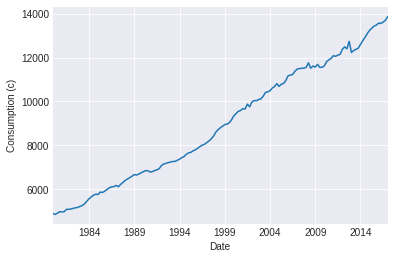

In [6]:
# However, our consumption data is non-stationary and this drives the previous
# estimate.
df.DPIC96.plot()
plt.xlabel('Date')
plt.ylabel('Consumption (c)')

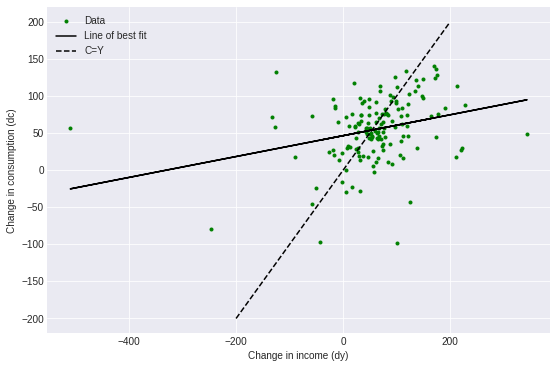

a_1 is 0.14075180213176058


In [7]:
# Lets use our second equation to try to find an estimate of a_1

df_diff = df.diff() #create dataframe of differenced values

# Plot the data
plt.figure(figsize=(9,6))
plt.plot(df_diff.DPIC96, df_diff.PCECC96, 'go', markersize=3.0, label = 'Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df_diff.DPIC96[1:], df_diff.PCECC96[1:]) # find line of best fit
plt.plot(df_diff.DPIC96[1:], intercept+slope*df_diff.DPIC96[1:], 'k-', label = 'Line of best fit')
plt.plot(np.array([-200, 200]), np.array([-200, 200]), 'k--', label = 'C=Y')
plt.xlabel('Change in income (dy)')
plt.ylabel('Change in consumption (dc)')
plt.legend()
plt.show()

print('a_1 is ' +  str(slope))

a_1 is now much lower, as we expected

### Household Data:

Cross-section plots of consumption and income: very large and significant $a_0$, $a_1$ maybe 0.5. <br>

Further facts:
1. Black households save more than whites at a given income level.<br>
0. By income group:
   * low-income: Implausibly large dissaving (spend 2 or 3 times income)
   * high-income: Remarkably high saving

### 2. Duesenberry

Habit formation may explain why $c_{t-1}$ affects $c_t$.<br>
Relative Income Hypothesis suggests that you compare your consumption to consumption of ‘peers’.<br>
May explain high saving rates of black HHs.<br>

Problems with Duesenberry: <br>
No budget constraint<br>
No serious treatment of intertemporal nature of saving

#### Dusenberry: Evidence

In [8]:
# Even if we control for income, past consumption seems to be significantly related to current consumption

df_habit = df.copy()
df_habit.columns = ['cons', 'inc']
df_habit['cons_m1'] = df.PCECC96.shift()
df_habit.dropna()

result = sm.ols(formula = "cons ~ inc + cons_m1", data=df_habit.dropna()).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cons   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.613e+05
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          1.33e-258
Time:                        15:08:03   Log-Likelihood:                -761.27
No. Observations:                 148   AIC:                             1529.
Df Residuals:                     145   BIC:                             1538.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.0236     15.017      0.601      0.549     -20.657      38.704
inc            0.0611      0.025      2.493      0.014       0.013       0.110
cons_m1        0.9371      0.026     35.527      0.000       0.885       0.989
==============================================================================
Omnibus:                       18.409   Durbin-Watson:                   1.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.989
Skew:                          -0.733   Prob(JB):                     6.18e-06
Kurtosis:                       4.320   Cond. No.                     5.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# This regression is clearly problematic for the usual non-stationary reasons.
# Nevertheless we see that the coefficient on lagged consumption is very significant.

### 3. Friedman's Permanent Income Hypothesis

$$c = p + u$$
$$y = p + v$$

We can try to test this theory across households. If we run a regression of the form:
$$c_i = a_0 + a_{1}y_{i} + u_{i}$$

And if Friedman is correct, and the "true" coefficient on permanent income $p$ is 1, then the coefficient on $y$ will be:
$$a_1 = \frac{s^2_{p}}{(s^2_{v} + s^2_{p})}$$

#### Friedman's Permanent Income Hypothesis: HARK

We begin by creating a class that class implements the Friedman PIH consumption function as a special case of the [Perfect Foresight CRRA](http://econ.jhu.edu/people/ccarroll/courses/choice/lecturenotes/consumption/PerfForesightCRRA) model.

In [10]:
class FriedmanPIHConsumer:
    """
    This class represents consumers that behave according to
    Friedman's permanent income hypothesis, representing them as a
    special case of HARK's PerfForesightConsumerType
    
    Methods:
    - cFunc: computes consumption/permanent income 
             given total income/permanent income.
    """
    
    def __init__(self, Rfree=1.001, CRRA = 2):
        
        PFaux = PerfForesightConsumerType() # set up a consumer type and use default parameteres
        PFaux.cycles = 0 # Make this type have an infinite horizon
        PFaux.DiscFac = 1/Rfree
        PFaux.Rfree = Rfree
        PFaux.LivPrb = [1.0]
        PFaux.PermGroFac = [1.0]
        PFaux.CRRA = CRRA
        PFaux.solve() # solve the consumer's problem
        PFaux.unpackcFunc() # unpack the consumption function
        
        self.cFunc = PFaux.solution[0].cFunc

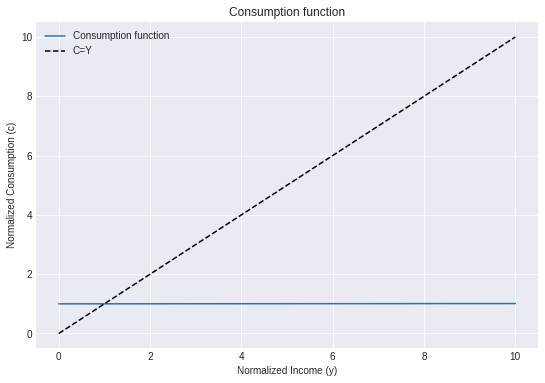

In [11]:
# We can now create a PIH consumer
PIHexample = FriedmanPIHConsumer()

# Plot the perfect foresight consumption function
income = np.linspace(0, 10, 20) # pick some income points
plt.figure(figsize=(9,6))
plt.plot(income, PIHexample.cFunc(income), label = 'Consumption function') #plot income versus the consumption
plt.plot(income, income, 'k--', label = 'C=Y')
plt.title('Consumption function')
plt.xlabel('Normalized Income (y)')
plt.ylabel('Normalized Consumption (c)')
plt.legend()
plt.show()

In [12]:
# We can see that regardless of the income our agent recieves, they consume their permanent income, normalised to 1

We can also draw out some implications of the PIH that we can then test with evidence

If we look at HH's who have very similar permanent incomes, we should get a small estimate of $a_1$, because $s^2_v$ is large relative to $s^2_p$.

Lets simulate this using our HARK consumer.

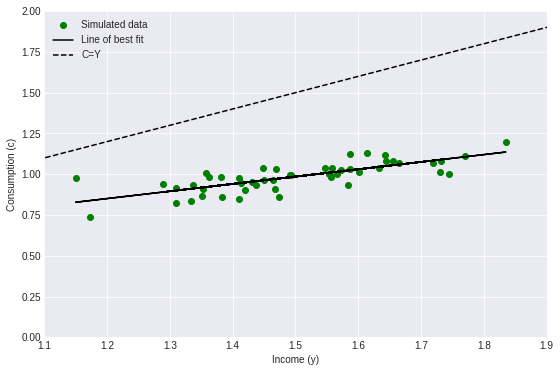

a_0 is 0.31169260388680387
a_1 is 0.44917414109321535


In [13]:
# Permanent income has the same variance
# as transitory income.

perm_inc = np.random.normal(1., 0.1, 50)
trans_inc = np.random.normal(0.5, 0.1, 50)

total_inc = perm_inc + trans_inc

slope, intercept, r_value, p_value, std_err = stats.linregress(total_inc, PIHexample.cFunc(total_inc)*perm_inc)

plt.figure(figsize=(9,6))
plt.plot(total_inc, PIHexample.cFunc(total_inc)*perm_inc, 'go', label='Simulated data')
plt.plot(total_inc, intercept + slope*total_inc, 'k-', label='Line of best fit')
plt.plot(np.linspace(1, 2, 5), np.linspace(1, 2, 5), 'k--', label='C=Y')
plt.xlabel('Income (y)')
plt.ylabel('Consumption (c)')
plt.legend()
plt.ylim(0, 2)
plt.xlim(1.1, 1.9)
plt.show()

print('a_0 is ' + str(intercept))
print('a_1 is ' +  str(slope))

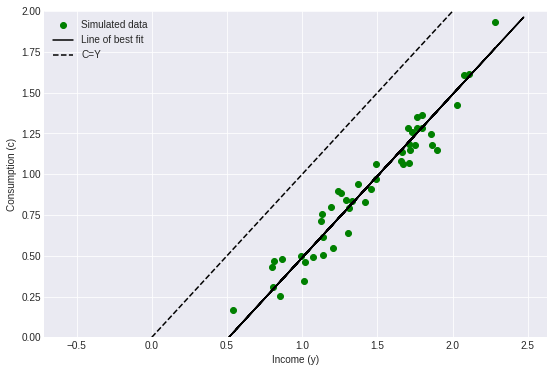

a_0 is -0.5133915222999756
a_1 is 1.0017736658728384


In [14]:
# Permanent income with higher variance

perm_inc = np.random.normal(1., 0.5, 50)
trans_inc = np.random.normal(0.5, 0.1, 50)

total_inc = perm_inc + trans_inc

slope, intercept, r_value, p_value, std_err = stats.linregress(total_inc, PIHexample.cFunc(total_inc)*perm_inc)

plt.figure(figsize=(9,6))
plt.plot(total_inc, PIHexample.cFunc(total_inc)*perm_inc, 'go', label='Simulated data')
plt.plot(total_inc, intercept + slope*total_inc, 'k-', label='Line of best fit')
plt.plot(np.linspace(0, 2, 5), np.linspace(0, 2, 5), 'k--', label='C=Y')
plt.xlabel('Income (y)')
plt.ylabel('Consumption (c)')
plt.legend()
plt.ylim(0, 2)
plt.show()

print('a_0 is ' + str(intercept))
print('a_1 is ' +  str(slope))

In [15]:
# We can see that as we increase the variance of permanent income, the estimate of a_1 rises

#### Friedman's Permanent Income Hypothesis: Evidence

We can now consider the empirical evidence for the claims our HARK model made about the PIH.

If we take a long time series, then the differences in permanent income should be the main driver of the variance in total income. This implies that a_1 should be high.

If we take higher frequency time series (or cross sectional data), transitory shocks should dominate, and our estimate of a_1 should be lower.

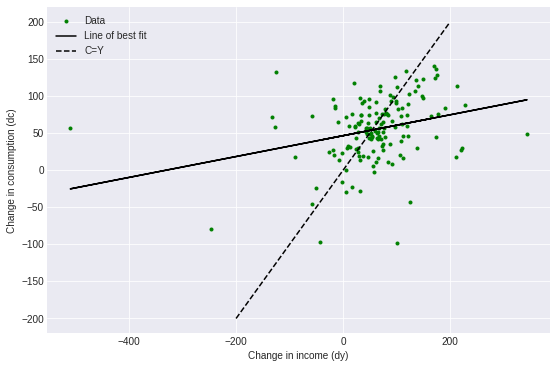

a_1 is 0.14075180213176058


In [16]:
# Lets use the data from FRED that we used before.

# Using quarterly data (copying from above), we had:

plt.figure(figsize=(9,6))
plt.plot(df_diff.DPIC96, df_diff.PCECC96, 'go', markersize=3.0, label = 'Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df_diff.DPIC96[1:], df_diff.PCECC96[1:]) # find line of best fit
plt.plot(df_diff.DPIC96[1:], intercept+slope*df_diff.DPIC96[1:], 'k-', label = 'Line of best fit')
plt.plot(np.array([-200, 200]), np.array([-200, 200]), 'k--', label = 'C=Y')
plt.xlabel('Change in income (dy)')
plt.ylabel('Change in consumption (dc)')
plt.legend()
plt.show()

print('a_1 is ' +  str(slope))

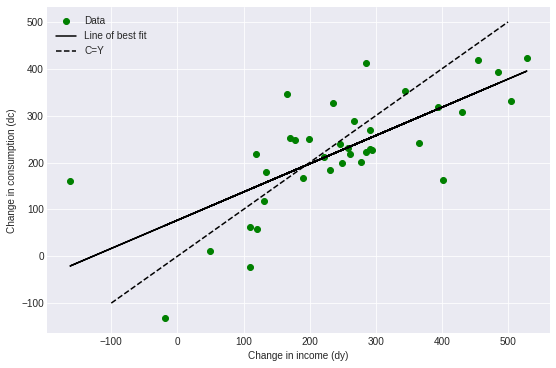

a_0 is 76.89850630443041
a_1 is 0.6022604126597904


In [17]:
# Using annual data

sdt = dt.datetime(1980, 1, 1) #set startdate
edt = dt.datetime (2017, 1, 1) #set end date
#df_an = web.DataReader(["PCECCA", "A067RX1A020NBEA"], "fred", sdt, edt) #import the annual data from Fred
annual_data_string = """DATE,PCECCA,A067RX1A020NBEA
1980-01-01,4242.809,4905.562
1981-01-01,4301.639,5025.39
1982-01-01,4364.607,5135.005
1983-01-01,4611.691,5312.201999999999
1984-01-01,4854.3009999999995,5677.121
1985-01-01,5105.633,5847.602
1986-01-01,5316.4,6069.76
1987-01-01,5496.928000000001,6204.052
1988-01-01,5726.528,6495.991999999999
1989-01-01,5893.491,6686.177
1990-01-01,6012.19,6817.3859999999995
1991-01-01,6023.043000000001,6867.004
1992-01-01,6244.696,7152.945
1993-01-01,6462.244000000001,7271.057
1994-01-01,6712.616999999999,7470.578
1995-01-01,6910.673000000001,7718.882
1996-01-01,7150.47,7964.2119999999995
1997-01-01,7419.722,8255.766
1998-01-01,7813.79,8740.44
1999-01-01,8225.37,9025.6
2000-01-01,8643.351999999999,9479.463
2001-01-01,8861.067,9740.106
2002-01-01,9088.689,10034.51
2003-01-01,9377.496,10301.426
2004-01-01,9729.331,10645.921999999999
2005-01-01,10075.884,10811.621000000001
2006-01-01,10384.546999999999,11241.948999999999
2007-01-01,10615.344,11500.252
2008-01-01,10592.837,11610.77
2009-01-01,10459.97,11591.659
2010-01-01,10642.98,11822.12
2011-01-01,10843.831,12099.788
2012-01-01,11006.813999999998,12501.196000000002
2013-01-01,11166.86,12339.128999999999
2014-01-01,11497.415,12844.273000000001
2015-01-01,11921.228000000001,13372.732
2016-01-01,12247.469,13608.408000000001
2017-01-01,12566.948,14002.78"""

df_an = pd.read_csv(StringIO(annual_data_string),
                    parse_dates = ['DATE'],
                    index_col = [0])

df_an_diff = df_an.diff()
df_an_diff.columns = ['cons', 'inc']

plt.figure(figsize=(9,6))
plt.plot(df_an_diff.inc, df_an_diff.cons, 'go', label='Data')
slope, intercept, r_value, p_value, std_err = stats.linregress(df_an_diff.inc[1:], df_an_diff.cons[1:]) # find line of best fit
plt.plot(df_an_diff.inc[1:], intercept+slope*df_an_diff.inc[1:], 'k-', label='Line of best fit')
plt.plot(np.linspace(-100, 500, 3), np.linspace(-100, 500, 3), 'k--', label='C=Y')
plt.legend()
plt.xlabel('Change in income (dy)')
plt.ylabel('Change in consumption (dc)')
plt.show()

print('a_0 is ' + str(intercept))
print('a_1 is ' +  str(slope))

In [18]:
# The estimate of a_1 using the annual data is much higher because permanent income is playing a much more important role
# in explaining the variation in consumption.